# Machine Learning Titanic 
Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The gradient classifier and logistic regression are the best two models that provide the highest best score. Interestingly, the gradient classifier does not have a high AUC but the results cross validate into the test dataset without overfitting the data. 

# Metrics
The AUC regression results:
* Logistic reg    0.8759
* Linear reg      0.8765
* Graident reg    0.8739
* Decision reg    0.8667
* Forest reg      0.8503
* Knn reg         0.645

The AUC classifier results:
* Forest   Classifier     0.8503 || MAE  0.19
* Gradient Classifier     0.7609 || MSE 0.2090
* Decision Classifier     0.7345 || MSE  0.4771 
* KNN      Classifier     0.5975 || MSE  0.5325

# Train Data
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and whether they survive or not. The shape of the train data is (891, 12). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
from math import sqrt

train=r'/kaggle/input/titanic/train.csv'
test=r'/kaggle/input/titanic/test.csv'

df=pd.read_csv(train)
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
dtype: float64


# Feature Engineer
We need to replace male and female into numbers. This is a very important part of the process because gender is one of the highest predictors on if a person survived or not.

In [4]:
#GENDER
df['Sex']=df['Sex'].map({'female':0,'male':1})

Females whose number is 0 had a much higher chance of surving than males. Later on, doing the importance feature analysis we will view that gender is actually one of the highest predictors. 

Being a wife make no difference in the final prediction: <br>
df['Titles'] = df['Name'].str.extract(r', (\w+\.)') <br>
df['Titles'] = df['Titles'].apply(lambda x: 1 if x=='Mrs.' else 0)

In [5]:
genderTable = pd.crosstab(df['Survived'],df['Sex'])
genderTable

Sex,0,1
Survived,,
0,81,468
1,233,109


#### Embarked Column

In [6]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [7]:
df['Embarked'].fillna(0)
embarkedTable = pd.crosstab(df['Survived'],df['Embarked'])
embarkedTable

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [8]:
df['Embarked']=df['Embarked'].map({'C':0,'Q':0, 'S':1})
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1.0


# Examine Target Variable
Survived is the Y variable we will be analyzing. Since the survival rete is 0.384 the data is not considered unbalanced. 

In [9]:
temp=df['Survived'].value_counts()
print(temp)
no=temp[0]
yes=temp[1]
percent=round(yes/(yes+no),3)
print("Percent that survived: ", percent)

0    549
1    342
Name: Survived, dtype: int64
Percent that survived:  0.384


# Numeric DataFrame
For now, we will analyze only numeric values. Categorical values will need to be encoded or analyzed individually.

In [10]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,1.0
1,2,1,1,0,38.0,1,0,71.2833,0.0
2,3,1,3,0,26.0,0,0,7.9250,1.0
3,4,1,1,0,35.0,1,0,53.1000,1.0
4,5,0,3,1,35.0,0,0,8.0500,1.0


# Check for missing values
Age is missing around 20% of values.Therefore, we can simply fill in the mean for that one column.

In [11]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
dtype: float64


In [12]:
df= df.fillna(df.mean())

# Split Data

In [13]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

# Highly Correlated Features
There are no highly correlated variables above 80%. Therefore, we do not need to be concerned about removing variables that are too highly correlated. 

# Gradient Boost 
The four parameters I tunned are max_depth, n_estimators, min_sample_split and learning_rate:
* The best max_depth is 2
* The best n_estimators is 500
* The best min_sample_split with least amount of error was at 7
* Having a higher learning rate makes AUC worse so I set it at .01

The full parameter reports are below: <br>
* 2  max_depth || AUC  0.8739  || MSE 0.1378
* 3  max_depth || AUC  0.8689  || MSE 0.1410
* 4  max_depth || AUC  0.86  || MSE 0.1407
* 5  max_depth || AUC  0.8567  || MSE 0.1485
* 100  n_estimators || AUC  0.8632  || MSE 0.1600
* 200  n_estimators || AUC  0.8726  || MSE 0.1471
* 300  n_estimators || AUC  0.8703  || MSE 0.1414
* 400  n_estimators || AUC  0.8732  || MSE 0.1389
* 500  n_estimators || AUC  0.874  || MSE 0.1378
* 2  min_samples_splits || AUC  0.8739  || MSE 0.1378
* 3  min_samples_splits || AUC  0.8738  || MSE 0.1378
* 5  min_samples_splits || AUC  0.8739  || MSE 0.1378

In [14]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5]
    
    for d in depthList:
        params = {
         "n_estimators": 500, "max_depth": d, "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        #print("Gradient boosting regression r2: ", gbr_r2) 

        #calculate AUC of model
        auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(d," max_depth || AUC ", auc, " || MSE {:.4f}".format(mse))

def gbN():
    nList=[100, 200, 300, 400, 500]
    
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        #print("Gradient boosting regression r2: ", gbr_r2) 

        #calculate AUC of model
        auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(n," n_estimators || AUC ", auc, " || MSE {:.4f}".format(mse))

def gbSplit():
    sList=[2, 3, 5, 7]
    
    for s in sList:
        params = {
         "n_estimators": 500, "max_depth": 2, "min_samples_split": s, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        #print("Gradient boosting regression r2: ", gbr_r2) 

        #calculate AUC of model
        auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(s," min_samples_splits || AUC ", auc, " || MSE {:.4f}".format(mse))

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

#### Gradient Boost Prediction
Use functions above to find the best paramters to input below.

In [15]:
params = {
 "n_estimators": 500, "max_depth": 2, 
    "min_samples_split": 7, "learning_rate": 0.01,
}

#Fit and Predict:
reg = ensemble.GradientBoostingClassifier(**params)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

#AUC of model
auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for gradient boost is: ", auc)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Gradient boosting regression r2:  0.2311
AUC for gradient boost is:  0.7893
The mean squared error (MSE) on test set: 0.1866


# Feature Importance

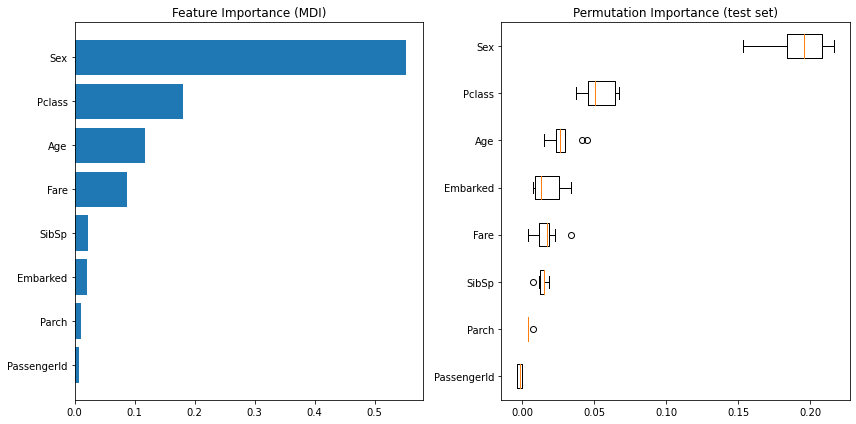

In [16]:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Logistic Regression
AUC for logistic regression is:  0.8779. Tuning the C value did not seem to make much difference in the final AUC prediction. 

#### Parameters Tuning
The Parameter C, the Grid Search is a way to tune the data. C parameter at 10 seems to give the highest AUC but it does not make much difference. The C parameter report gives the following:
* 0.01  C param || AUC:  0.8603  || MAE 0.2819
* 1  C param || AUC:  0.8759  || MAE 0.2819
* 2  C param || AUC:  0.8771  || MAE 0.2819
* 5  C param || AUC:  0.8778  || MAE 0.2819
* 10  C param || AUC:  0.8779  || MAE 0.2819


In [17]:
from sklearn.linear_model import LogisticRegression
#Note: solver param gets rid of encoder error

def logC():
    cList=[.01, 1, 2, 5, 10]
    for n in cList:
        logReg = LogisticRegression(solver='liblinear', C=n) 

        logReg.fit(X_train, y_train)
        logPredict = logReg.predict_proba(X_test)[::,1]

        auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
        mae = mean_absolute_error(y_test, y_pred).round(4)
        print(n, " C param || AUC: ", auc, " || MAE", mae) 
#logC()

#### Make Logistic Regression Prediction
Input the variables below from using the test functions above. Using l1 or l2 for penalty does not make a major difference in final AUC.

In [18]:
num=10
logReg = LogisticRegression(solver='liblinear',penalty='l2', C=num) 

#Train the model and create predictions
logReg.fit(X_train, y_train)
logPredict = logReg.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
print("AUC for logistic regression is: ", auc)

AUC for logistic regression is:  0.8769


# Linear Regression

AUC for linear regression is:  0.8759
Linear regression r2 score:  0.438
Linear Accuracy:  0.438
0.3697  linear regression cross validate mean
0.3693  is lr MSE 


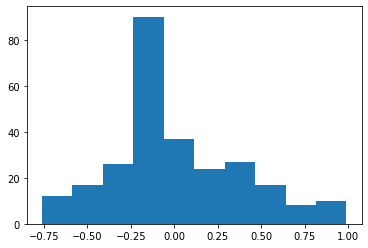

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
print("AUC for linear regression is: ", auc)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

lrMSE=np.sqrt(metrics.mean_squared_error(y_test, lrPredict))
print(round(lrMSE, 4), " is lr MSE ")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)

# Decision Tree
After running the below functions it was discovered that the best parameters are the following:
* max_leaf_nodes=5  
* max_depth=5

The full parameter reports are below: <br>
* 5  max_leaf_nodes || AUC  0.8084  || MAE:  0.2743
* 25  max_leaf_nodes || AUC  0.8084  || MAE:  0.2584
* 50  max_leaf_nodes || AUC  0.8084  || MAE:  0.2611
* 100  max_leaf_nodes || AUC  0.8084  || MAE:  0.2541
* 250  max_leaf_nodes || AUC  0.8084  || MAE:  0.25
* 500  max_leaf_nodes || AUC  0.8084  || MAE:  0.25
* 2  max_depth || AUC  0.8084  || MAE:  0.2854
* 3  max_depth || AUC  0.8203  || MAE:  0.2656
* 5  max_depth || AUC  0.8432  || MAE:  0.2526
* 7  max_depth || AUC  0.7847  || MAE:  0.2573

In [20]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
        print(leaf, " max_leaf_nodes || AUC ", treeAUC, " || MAE: ", mae)
    maxLeafNodes = sorted(maeDic, key=lambda x : maeDic[x])[0]
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeRegressor(max_leaf_nodes=100, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth with least error.") #10
    
def automateTree():
    print("Decision Tree Automating:")
    start=time.time()
    candidate_max_leaf_nodes = [5, 25, 50, 100, 200, 500]
    max_depth_list = [2, 3, 5, 7, 9]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, 
                                          max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeR2 = r2_score(y_test, y_pred).round(4)
            
            aucList.append(treeR2)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['AUC'], ascending=False)
    print("Done. ", round(time.time()-start,4), " seconds")
    return df

#TURN FUNCTION OFF OR ON BELOW:   
#calcLeaf()
#calcDepth()
#treeDF=automateTree()    
#treeDF.head()

#### Final Decision Tree Prediction
Inputs below such as best_depth by using functions above.

In [21]:
maxLeafNode=5
best_depth=5
    
#MAKE PREDICTION:
tree = DecisionTreeClassifier(max_depth=best_depth, 
                             max_leaf_nodes=maxLeafNode, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#Calculate Metrics:
treeR2 = r2_score(y_test, y_pred).round(4)
print(treeR2, " R2 Decision Tree")
treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", treeAUC)
treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(round(treeMSE, 4), " is tree MSE ")

0.0619  R2 Decision Tree
AUC for decision tree is:  0.7345
0.4771  is tree MSE 


# Random Forest
Random forest AUC:  0.8503 which provided descent results in comparision to the other models. 

<b>n_estimates</b> <br>
The best n_estimates with high AUC seems to be 400. Error is not impacted by the change of n_estimates. The full report can be seen below: <br>
* 2  n_estimates |  0.7962  AUC |  0.24  MAE
* 102  n_estimates |  0.843  AUC |  0.25  MAE
* 202  n_estimates |  0.8459  AUC |  0.25  MAE
* 302  n_estimates |  0.8492  AUC |  0.25  MAE
* 402  n_estimates |  0.8505  AUC |  0.25  MAE
* 502  n_estimates |  0.8489  AUC |  0.25  MAE

In [22]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#Check for Error and find Best n_estimators:
def checkMAE():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    for n in range(2, 601, 100):
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        dMAE[n]=MAE
        print(n, " n_estimates | ", forest_auc, " AUC | ", MAE, " MAE")
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
#checkMAE() #turn function on or off by uncommenting

#### Final Random Forest Prediction

In [23]:
forestEst=400
forest = RandomForestClassifier(n_estimators=forestEst, random_state = 0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forest_r2 = r2_score(y_test, y_pred).round(4)  
forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("Random forest AUC: ", forest_auc) 
print("Random forest r2: ", forest_r2)

mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Random forest MAE: ", mae)

Random forest AUC:  0.7856
Random forest r2:  0.2003
Random forest MAE:  0.19


# K-Nearest Neighbors (KNN)

#### KNN Parameter Tunning

Finding best n_neighbors value:


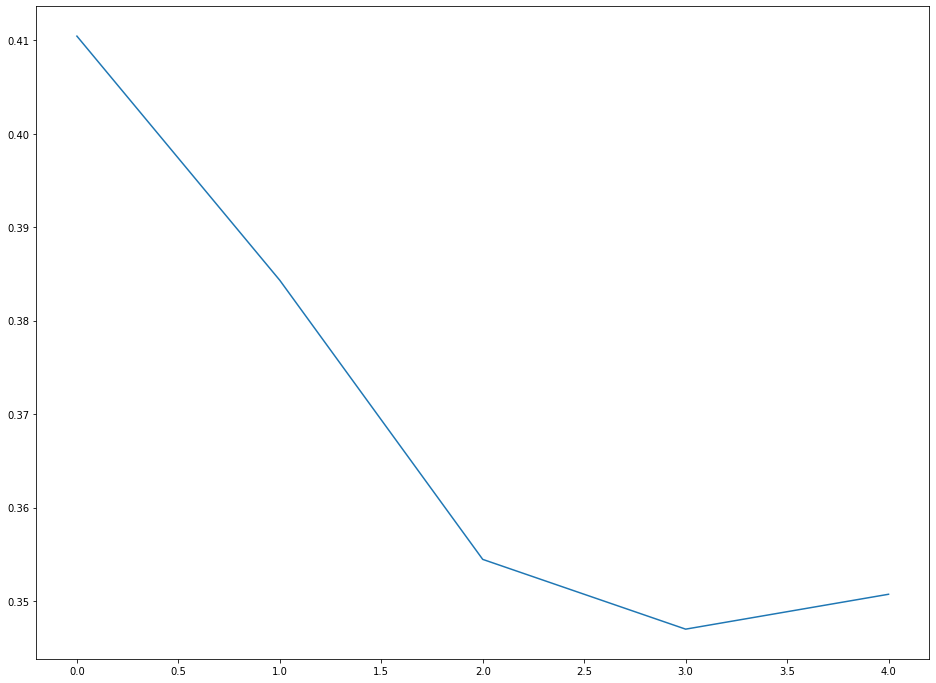

In [24]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

def knnError():
    print("Finding best n_neighbors value:")
    error_rates = []
    for i in range(1, 10, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))
    plt.figure(figsize=(16,12))
    plt.plot(error_rates)
knnError()

#### Final KNN Prediction

In [25]:
n_num=3 #Input from knnError function

#Train the model and make predictions:
knn = KNeighborsClassifier(n_neighbors =n_num) 
knn.fit(X_train, y_train)
knnPredict = knn.predict_proba(X_test)[::,1]

#calculate AUC of model
knn_auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
print("Knn AUC: ", knn_auc)
error = round(sqrt(mean_squared_error(y_test,knnPredict)), 4)
print("MSE ", error)

Knn AUC:  0.5975
MSE  0.5325


# Support Vector Machine (SVM)
The initial results for SVM AUC with no parameter tunning is 0.5336.  The model does not seem worth investing lots of time into due to poor AUC performance. 

#### GridSearch Tune
The best parameters from tunning SVM is SVC(C=1000, gamma=0.0001).

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
 
def tuneSVM():
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

#### Final SVM Prediction

In [27]:
#Fit and Predict:
svc = SVC(C=1000, gamma=0.0001)
svc.fit(X_train, y_train)
svc_predit = svc.predict(X_test)

#calculate AUC of model
svmAUC = round( metrics.roc_auc_score(y_test, svc_predit), 4 ) 
print("SVC AUC is: ", svmAUC)

svmMAE=round( metrics.mean_absolute_error(y_test, svc_predit), 4)
print("SVC MAE is: ", svmMAE)

print(classification_report(y_test, svc_predit))

SVC AUC is:  0.7619
SVC MAE is:  0.2201
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       157
           1       0.78      0.66      0.71       111

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268



/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


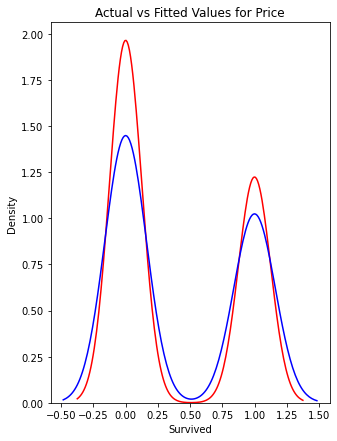

In [28]:
plt.figure(figsize=(5, 7))
ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

# Test Data

In [29]:
test=pd.read_csv(test)

#GENDER
test['Sex']=test['Sex'].map({'female':0,'male':1})

#EMBARKED
test['Embarked']=test['Embarked'].map({'C':0,'Q':0, 'S':1})

features=list(X.columns)
test=test[features]

test=test.fillna(test.mean())
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,0
1,893,3,0,47.0,1,0,7.0000,1
2,894,2,1,62.0,0,0,9.6875,0
3,895,3,1,27.0,0,0,8.6625,1
4,896,3,0,22.0,1,1,12.2875,1


# Make Final Prediction

In [30]:
test_predictions = reg.predict(test)
#test_predictions=np.where(test_predictions<.5, 0, test_predictions)
#test_predictions=np.where(test_predictions>.5, 1, test_predictions)
passID=test['PassengerId']
tupleData = list(zip(passID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Survived'])
output.head(7)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1


In [31]:
sample=r'/kaggle/input/titanic/gender_submission.csv'
sample=pd.read_csv(sample)

# Submit Predictions

In [32]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
